# Multivariate time series forecasting using LSTM(Long-Short Term Memory)
Working with multivariate time series forecasting using LSTM (Long-Short Term Memory), you'll need to modify the input data structure to include multiple features.

In [19]:
# Import essential libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
# from datetime import datetime
df= pd.read_csv('/content/TATAELXSI.NS.csv')

In [11]:
# Seprate dates for future plotting
train_dates= pd.to_datetime(df['Date'])
train_dates

0     2022-12-12
1     2022-12-13
2     2022-12-14
3     2022-12-15
4     2022-12-16
         ...    
242   2023-12-05
243   2023-12-06
244   2023-12-07
245   2023-12-08
246   2023-12-11
Name: Date, Length: 247, dtype: datetime64[ns]

In [12]:
# Variables for tranning
cols=list(df)[1:6]
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [8]:
df_for_training= df[cols].astype(float)

In [9]:
df_for_plot=df_for_training.tail(5000)

<Axes: >

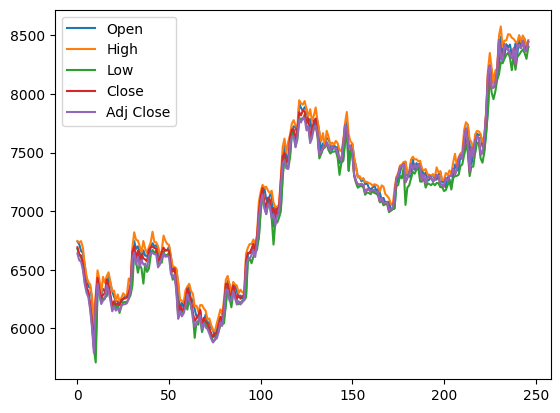

In [10]:
df_for_plot.plot.line()

In [14]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# Normalize the data set
scaler= StandardScaler()
scaler.fit(df_for_training)
df_for_training_scaled= scaler.transform(df_for_training)
df_for_training

,Open,High,Low,Close,Adj Close
0,6742.000000,6745.000000,6680.0,6692.250000,6640.194336
1,6718.000000,6734.000000,6625.0,6632.600098,6581.008789
2,6659.950195,6744.399902,6611.0,6621.200195,6569.697266
3,6645.000000,6687.700195,6545.0,6550.350098,6499.398438
4,6535.100098,6544.799805,6401.0,6429.399902,6379.389160
...,...,...,...,...,...
242,8402.049805,8443.349609,8360.0,8392.099609,8392.099609
243,8431.049805,8499.000000,8380.0,8454.549805,8454.549805
244,8469.000000,8469.000000,8350.0,8365.450195,8365.450195
245,8370.049805,8409.750000,8300.0,8365.849609,8365.849609


In [18]:
#As required for LSTM networks, we require to reshape an input data into  n_sample * timestep * n_features
# In this example, the n_features is 2 . We will make time steps=3.
# With this, the resultant n_sample is 5 (as the input data has 9 rows)

train_x=[]
train_y=[]

n_future=1 # Number of days we want to predict into the future
n_past=14  # Number of past days we want to use to  predict the future

for i in range(n_past, len(df_for_training_scaled)- n_future+1):
  train_x.append(df_for_training_scaled[i- n_past:i, 0:df_for_training.shape[1]])
  train_y.append(df_for_training_scaled[i+ n_future-1:i+ n_future,0])

train_x, train_y= np.array(train_x), np.array(train_y)

print('train_x shape =={}.'.format(train_x.shape))
print('train_y shape =={}.'.format(train_y.shape))


train_x shape ==(233, 14, 5).
train_y shape ==(233, 1).


In [20]:
# Define LSTM model
model =Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_x.shape[1],train_x.shape[2]), return_sequences= True))
model.add(LSTM(32, activation='relu', return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))

In [36]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


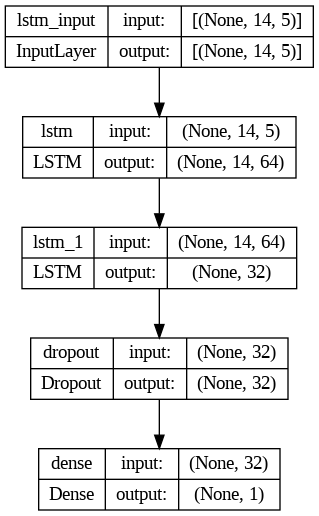

In [37]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [38]:
# Fitting model
history = model.fit(train_x, train_y, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
14/14 [==============================] - 5s 65ms/step - loss: 0.0172 - val_loss: 0.0629
Epoch 2/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0203 - val_loss: 0.0191
Epoch 3/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0179 - val_loss: 0.0619
Epoch 4/100
14/14 [==============================] - 0s 23ms/step - loss: 0.0225 - val_loss: 0.0236
Epoch 5/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0153 - val_loss: 0.0492
Epoch 6/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0172 - val_loss: 0.0205
Epoch 7/100
14/14 [==============================] - 0s 24ms/step - loss: 0.0187 - val_loss: 0.0559
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0193 - val_loss: 0.0442
Epoch 9/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0227 - val_loss: 0.0267
Epoch 10/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0198 - val_loss: 0.0323

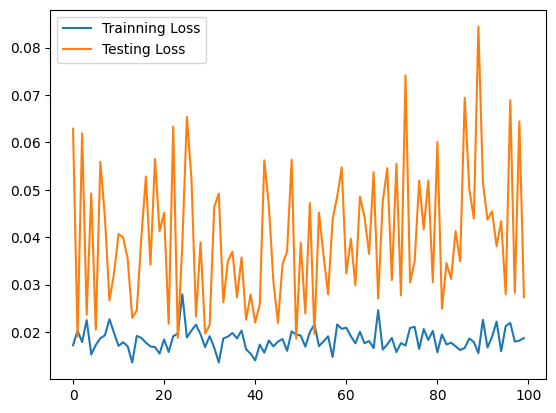

In [39]:
plt.plot(history.history['loss'], label='Trainning Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.legend()

In [53]:
# Forecasting
# Start with the last day in trainning date and predict future
n_future=90 # Redefining n_future to extend prediction dates beyond original n_future dates

forecast_period_dates= pd.date_range(list(train_dates)[-1], periods= n_future, freq='1d').tolist()
forecast_period_dates

[Timestamp('2023-12-11 00:00:00', freq='D'),
 Timestamp('2023-12-12 00:00:00', freq='D'),
 Timestamp('2023-12-13 00:00:00', freq='D'),
 Timestamp('2023-12-14 00:00:00', freq='D'),
 Timestamp('2023-12-15 00:00:00', freq='D'),
 Timestamp('2023-12-16 00:00:00', freq='D'),
 Timestamp('2023-12-17 00:00:00', freq='D'),
 Timestamp('2023-12-18 00:00:00', freq='D'),
 Timestamp('2023-12-19 00:00:00', freq='D'),
 Timestamp('2023-12-20 00:00:00', freq='D'),
 Timestamp('2023-12-21 00:00:00', freq='D'),
 Timestamp('2023-12-22 00:00:00', freq='D'),
 Timestamp('2023-12-23 00:00:00', freq='D'),
 Timestamp('2023-12-24 00:00:00', freq='D'),
 Timestamp('2023-12-25 00:00:00', freq='D'),
 Timestamp('2023-12-26 00:00:00', freq='D'),
 Timestamp('2023-12-27 00:00:00', freq='D'),
 Timestamp('2023-12-28 00:00:00', freq='D'),
 Timestamp('2023-12-29 00:00:00', freq='D'),
 Timestamp('2023-12-30 00:00:00', freq='D'),
 Timestamp('2023-12-31 00:00:00', freq='D'),
 Timestamp('2024-01-01 00:00:00', freq='D'),
 Timestamp

In [54]:
forecast= model.predict(train_x[-n_future:])
forecast

3/3 [==============================] - 0s 8ms/step


array([[ 0.29592067],
       [ 0.21303177],
       [ 0.22324327],
       [ 0.21103096],
       [ 0.18283564],
       [ 0.20726097],
       [ 0.18465063],
       [ 0.16971672],
       [ 0.15976007],
       [ 0.07121077],
       [ 0.08112185],
       [ 0.03700447],
       [ 0.01584487],
       [ 0.03185157],
       [-0.03181032],
       [-0.03436171],
       [-0.00734822],
       [ 0.13643871],
       [ 0.3741501 ],
       [ 0.39847422],
       [ 0.5017292 ],
       [ 0.50387186],
       [ 0.5426352 ],
       [ 0.35694945],
       [ 0.38784605],
       [ 0.41818297],
       [ 0.5319203 ],
       [ 0.47522902],
       [ 0.53724164],
       [ 0.5048538 ],
       [ 0.55789715],
       [ 0.49200112],
       [ 0.38562647],
       [ 0.41623145],
       [ 0.3341465 ],
       [ 0.36179864],
       [ 0.37920308],
       [ 0.36314985],
       [ 0.3360123 ],
       [ 0.34169638],
       [ 0.3746775 ],
       [ 0.37252295],
       [ 0.29912287],
       [ 0.28518134],
       [ 0.26237264],
       [ 0

In [55]:
# Perform iverse transformation to rescale back to original range
# Since we used 5 variables for transform , the inverse expect same dimensions
# Therefore , let us copy our values 5 times and discrd them after inverse transform

forecast_copies= np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]
y_pred_future

array([7265.    , 7209.7065, 7216.5186, 7208.372 , 7189.5635, 7205.8574,
       7190.7744, 7180.8125, 7174.1704, 7115.101 , 7121.713 , 7092.283 ,
       7078.168 , 7088.8457, 7046.3784, 7044.6763, 7062.6963, 7158.6133,
       7317.185 , 7333.411 , 7402.29  , 7403.7197, 7429.5776, 7305.711 ,
       7326.3213, 7346.5586, 7422.43  , 7384.613 , 7425.98  , 7404.3745,
       7439.759 , 7395.801 , 7324.841 , 7345.257 , 7290.4995, 7308.946 ,
       7320.5557, 7309.847 , 7291.744 , 7295.536 , 7317.537 , 7316.0996,
       7267.136 , 7257.836 , 7242.621 , 7283.6133, 7276.454 , 7309.9355,
       7311.711 , 7363.915 , 7345.6865, 7365.056 , 7441.041 , 7475.243 ,
       7460.0796, 7616.6494, 7694.6294, 7552.163 , 7433.348 , 7584.973 ,
       7493.8213, 7653.6724, 7644.9263, 7627.6543, 7517.475 , 7554.515 ,
       7641.8564, 7834.3047, 8174.909 , 8029.758 , 7911.249 , 8083.0356,
       8095.13  , 8219.109 , 8496.244 , 8036.15  , 8408.65  , 8385.523 ,
       8307.681 , 8437.045 , 8296.975 , 8368.259 , 

<ipython-input-60-da3b7494b68d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


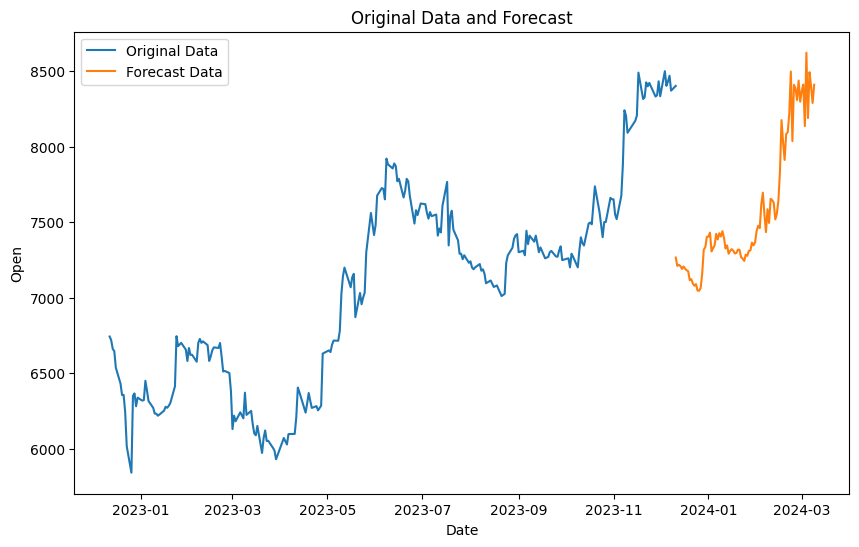

In [60]:
# Convert timestamps to date

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Open', data=original, label='Original Data')
sns.lineplot(x='Date', y='Open', data=df_forecast, label='Forecast Data')

plt.title('Original Data and Forecast')
plt.xlabel('Date')
plt.ylabel('Open')
plt.legend()
plt.show()